In [1]:
import numpy as np
from scipy import *
from pylab import *
import healpy as hp
import os
from healpy import pixelfunc
from aperture_mass_computer import aperture_mass_computer
from helpers_plot import initPlot, finalizePlot, prepareMap3Plot

# Measurements of $\langle M_\mathrm{ap}^3\rangle$ from shear catalogues
In this notebook we take flattened sky fields from the simulations and measure the third-order aperture statistics using the shear catalogues

Author: Laila Linke

The Map3 measurement code is developed together with Sven Heydenreich, the Read-in of the simulations is based on the example notebook by Joachim Harnois-Déraps and Jia Liu

In [2]:
thetas=[4,8,16,32] # Aperture radii to use [arcmin]
Nthetas=len(thetas)
# Filenames
######## shape catalogues of 3 different resolutions
## 6 columns: [ra_degree, dec_degree, shear1, shear2, weight, kappa]

# 0.06 gal/sq.arcmin
fn_cat006 = '/global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/zs_plane/GalCat_zplane_zs1.006_0.06GpAM_RA_Dec_gamma1_gamma2_w_kappa.asc'
# 0.6 gal/sq.arcmin
fn_cat06 = '/global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/zs_plane/GalCat_zplane_zs1.006_0.6GpAM_RA_Dec_gamma1_gamma2_w_kappa.asc'
# 12 gal/sq.arcmin
fn_cat12 = '/global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/zs_plane/GalCat_zplane_zs1.006_1.2GpAM_RA_Dec_gamma1_gamma2_w_kappa.asc'

In [3]:
# Patches:


dec0s_ra0s=[(5,10), (5,30), (5, 50), (5,70), (15,20), (15, 40), (15, 60), 
            (25, 10), (25,30), (25, 50), (25, 70), (35,20), (35,40), (35, 60),
            (45, 10), (45,30), (45, 50), (45, 70), (55,20), (55,40), (55, 60),
            (65,30), (65, 50), (65, 70)] #Note that (65,10) doesn't work, as it cuts outside the octant!

Npatches=len(dec0s_ra0s)
mapsize = 10 # map size in degrees
res_arcmin = 0.5 # map resolution in arcmin/pix


Npix = int(mapsize*60/res_arcmin) # number of pixels to cut out (per side)

In [4]:
########## load catalogues

ngal="12" #Other options: 006, 12
if ngal=="06":
    cat=np.loadtxt(fn_cat06)
elif ngal=="006":
    cat=np.loadtxt(fn_cat006)
elif ngal=="12":
    cat=np.loadtxt(fn_cat12)
ra_degree, dec_degree,  shear1, shear2, weight, kappa = cat.T

In [5]:
# Cut out the patches
shears_patches=[]
norm_patches=[]
for dec0_ra0 in dec0s_ra0s:
    dec0=dec0_ra0[0]
    ra0=dec0_ra0[1]
    print(f"Processing patch centred on {ra0}, {dec0}")
    idx_flat = where((ra_degree < ra0+mapsize/2)
                         & (ra_degree > ra0-mapsize/2)
                         & (dec_degree < dec0+mapsize/2)
                         & (dec_degree > dec0-mapsize/2))
    ra_degree_cut=ra_degree[idx_flat]
    dec_degree_cut=dec_degree[idx_flat]
    shear1_cut=shear1[idx_flat]
    shear2_cut=shear2[idx_flat]
    weight_cut=weight[idx_flat]
    kappa_cut=kappa[idx_flat]

    # Distribute galaxies on grid
    shear_cat=-shear1_cut-1.0j*shear2_cut # Take negative of epsilon1
    ac=aperture_mass_computer(int(Npix), 1, mapsize*60)
    shears=ac.normalize_shear((ra_degree_cut-ra0+mapsize/2)*60, (dec_degree_cut-dec0+mapsize/2)*60, shear_cat, normalize=True, nan_treatment="linear")
    shears_patches.append(shears)


Processing patch centred on 10, 5
Processing patch centred on 30, 5
Processing patch centred on 50, 5
Processing patch centred on 70, 5
Processing patch centred on 20, 15
Processing patch centred on 40, 15
Processing patch centred on 60, 15
Processing patch centred on 10, 25
Processing patch centred on 30, 25
Processing patch centred on 50, 25
Processing patch centred on 70, 25
Processing patch centred on 20, 35
Processing patch centred on 40, 35
Processing patch centred on 60, 35
Processing patch centred on 10, 45
Processing patch centred on 30, 45
Processing patch centred on 50, 45
Processing patch centred on 70, 45
Processing patch centred on 20, 55
Processing patch centred on 40, 55
Processing patch centred on 60, 55
Processing patch centred on 30, 65
Processing patch centred on 50, 65
Processing patch centred on 70, 65


In [6]:
# Calculate the Aperture Mass Maps from the  shear
Maps_patches=[]
for i in range(Npatches):
    print(f"Processing {i+1} of {Npatches}")
    Maps=[]
    shears=shears_patches[i]
    #norm=norm_patches[i]
    for j,theta in enumerate(thetas):
        ac=aperture_mass_computer(int(Npix), theta, mapsize*60)
        map=ac.Map_fft(shears, periodic_boundary=False, norm=None)
        
        Maps.append(map)
    Maps_patches.append(Maps)

Processing 1 of 24
Processing 2 of 24
Processing 3 of 24
Processing 4 of 24
Processing 5 of 24
Processing 6 of 24
Processing 7 of 24
Processing 8 of 24
Processing 9 of 24
Processing 10 of 24
Processing 11 of 24
Processing 12 of 24
Processing 13 of 24
Processing 14 of 24
Processing 15 of 24
Processing 16 of 24
Processing 17 of 24
Processing 18 of 24
Processing 19 of 24
Processing 20 of 24
Processing 21 of 24
Processing 22 of 24
Processing 23 of 24
Processing 24 of 24


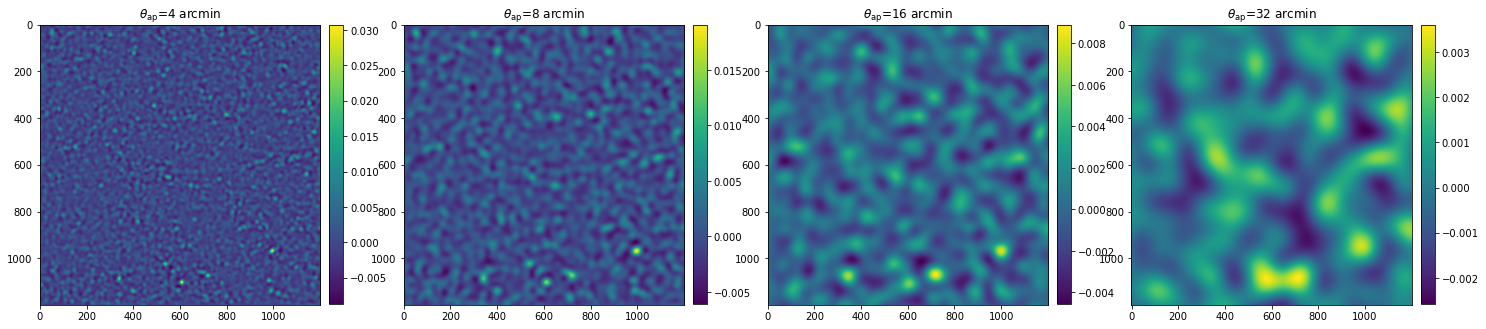

In [7]:
# Plotting of Aperture Mass Maps for one patch
fig, ax=plt.subplots(ncols=Nthetas, figsize=(25,10)) # For plotting
patch=0
for i in range(Nthetas):
    map=Maps_patches[patch][i]
    im=ax[i].imshow(map)
    fig.colorbar(im, ax=ax[i],fraction=0.046, pad=0.03)
    ax[i].set_title(r"$\theta_\mathrm{ap}$="+f"{thetas[i]} arcmin")

In [10]:
# Calculate third-order aperture statistics

Map3=np.zeros((Nthetas*(Nthetas+1)*(Nthetas+2)//6, Npatches))
for patch in range(Npatches):
    Maps=Maps_patches[patch]
    counter=0
    for i in range(Nthetas):
        for j in range(i, Nthetas):
            for k in range(j, Nthetas):
                # cut off boundaries
                maxtheta=thetas[k]
                index_maxtheta = int(np.round(maxtheta/(mapsize*60)*Npix*4))

                map3_mean=np.mean(Maps[i][index_maxtheta:(Npix-index_maxtheta), index_maxtheta:(Npix-index_maxtheta)]
                                  *Maps[j][index_maxtheta:(Npix-index_maxtheta), index_maxtheta:(Npix-index_maxtheta)]
                                  *Maps[k][index_maxtheta:(Npix-index_maxtheta), index_maxtheta:(Npix-index_maxtheta)])
                Map3[counter][patch]=map3_mean
                counter+=1
np.savetxt(f"MapMapMap_fromFlat_ShearCat_ngal_{ngal}.dat", Map3)

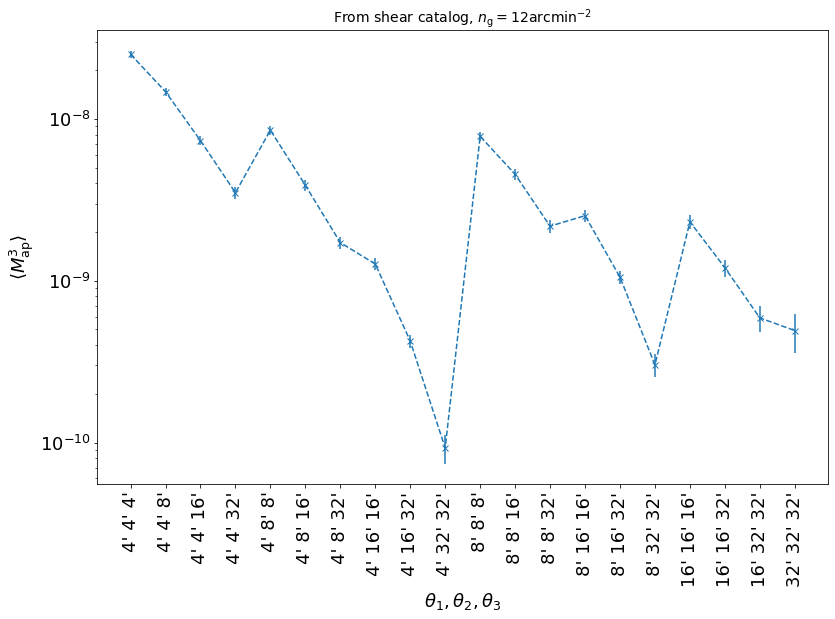

In [11]:
# Plot <Map³>
initPlot(usetex=False)

fig, ax=plt.subplots(figsize=(12,9))
prepareMap3Plot(ax)


ax.errorbar(range(len(Map3[:,0])), np.mean(Map3, axis=1), yerr=np.std(Map3, axis=1)/np.sqrt(Npatches), ls='--', marker='x')
ax.set_ylabel(r"$\langle M_\mathrm{ap}^3 \rangle$")

if ngal=="06":
    title=r"From shear catalog, $n_\mathrm{g}=0.6 \mathrm{arcmin}^{-2}$"
    outfn="MapMapMap_fromFlat_ShearCat_06.png"
elif ngal=="006":
    title=r"From shear catalog, $n_\mathrm{g}=0.06 \mathrm{arcmin}^{-2}$"
    outfn="MapMapMap_fromFlat_ShearCat_006.png"
    
elif ngal=="12":
    title=r"From shear catalog, $n_\mathrm{g}=12 \mathrm{arcmin}^{-2}$"
    outfn="MapMapMap_fromFlat_ShearCat_12.png"
    
finalizePlot(ax, title=title, outputFn=outfn, showlegend=False)